In [24]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Skipping, found downloaded files in "./animal-faces" (use force=True to force download)


In [25]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device available:", device)

device available: cuda


In [26]:
image_path = []
labels = []

for i in os.listdir("/content/animal-faces/afhq"):
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
      labels.append(label)

data_df = pd.DataFrame(zip(image_path,labels),columns=["image_path","labels"])
print(data_df["labels"].unique())

data_df.head()

['dog' 'wild' 'cat']


,image_path,labels
0,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
1,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
2,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
3,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
4,/content/animal-faces/afhq/train/dog/pixabay_d...,dog


In [27]:
#take 70% of data sample and assign it to train
train = data_df.sample(frac = 0.7)
#split the data for testing
test = data_df.drop(train.index)
#take 50% for validation
val = test.sample(frac=0.5)
test = test.drop(val.index)

print(train.shape)
print(val.shape)
print(test.shape)

(11291, 2)
(2420, 2)
(2419, 2)


In [28]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df["labels"])
#makes images have the same properties (size,datatype,etc.)
transform = transforms.Compose([
    #make the images the same size
    transforms.Resize((128,128)),
    #convert the images to tensors
    transforms.ToTensor(),
    #convert the images to float datatype
    transforms.ConvertImageDtype(torch.float)
])

In [29]:
class CustomImageDataset(Dataset):
  def __init__(self,dataframe,transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(dataframe["labels"])).to(device)
  def __len__(self):
    return self.dataframe.shape[0]
  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx,0]
    label = self.labels[idx]
    #open image and load it inside pytorch
    image = Image.open(img_path).convert('RGB')
    #transform the image
    if self.transform:
      image = self.transform(image).to(device)

    return image,label

In [30]:
train_dataset = CustomImageDataset(dataframe = train, transform = transform)
val_dataset = CustomImageDataset(dataframe = val, transform = transform)
test_dataset = CustomImageDataset(dataframe = test, transform = transform)

In [31]:
train_dataset.__getitem__(2)

(tensor([[[0.4000, 0.4118, 0.4118,  ..., 0.3529, 0.3529, 0.3059],
          [0.3804, 0.4000, 0.4078,  ..., 0.3373, 0.3529, 0.3216],
          [0.3725, 0.3843, 0.4078,  ..., 0.3216, 0.3451, 0.3255],
          ...,
          [0.4745, 0.6235, 0.6588,  ..., 0.2706, 0.3765, 0.4039],
          [0.4745, 0.5843, 0.6588,  ..., 0.3255, 0.4078, 0.3608],
          [0.3765, 0.5451, 0.6549,  ..., 0.3765, 0.4510, 0.4000]],
 
         [[0.6392, 0.6549, 0.6235,  ..., 0.6118, 0.6157, 0.5725],
          [0.6157, 0.6431, 0.6314,  ..., 0.5922, 0.6118, 0.5843],
          [0.6000, 0.6275, 0.6431,  ..., 0.5765, 0.6000, 0.5843],
          ...,
          [0.4510, 0.5922, 0.6078,  ..., 0.4431, 0.5922, 0.6275],
          [0.4588, 0.5569, 0.6196,  ..., 0.5098, 0.6275, 0.5922],
          [0.3647, 0.5216, 0.6196,  ..., 0.5804, 0.6667, 0.6078]],
 
         [[0.1686, 0.1804, 0.2118,  ..., 0.1843, 0.1725, 0.1137],
          [0.1647, 0.1882, 0.2196,  ..., 0.1804, 0.1804, 0.1373],
          [0.1765, 0.2000, 0.2392,  ...,

In [32]:
label_encoder.inverse_transform([0])

array(['cat'], dtype=object)

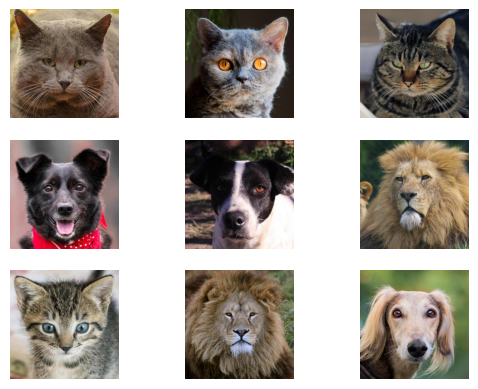

In [33]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows,n_cols)
for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert('RGB')
    axarr[row,col].imshow(image)
    axarr[row,col].axis("off")
plt.show()


In [34]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [35]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle = True)

In [43]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,32,kernel_size=3, padding=1) #output size is 32 but image size is 128
    self.conv2 = nn.Conv2d(32,64,kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64,128,kernel_size=3, padding=1)

    self.pooling = nn.MaxPool2d(2,2)

    self.relu = nn.ReLU()

    self.flatten = nn.Flatten()
    self.linear = nn.Linear((128*16*16),128)

    self.output = nn.Linear(128,len(data_df['labels'].unique()))

  def forward(self,x):
    x = self.conv1(x) #32,128,128
    x = self.pooling(x) #32,64,64
    x = self.relu(x)

    x = self.conv2(x) #64,64,64
    x = self.pooling(x) #64,32,32
    x = self.relu(x)

    x = self.conv3(x) #128,32,32
    x = self.pooling(x) #128,16,16
    x = self.relu(x)

    x = self.flatten(x)
    x = self.linear(x)
    x = self.output(x)
    return x


In [44]:
model = Net().to(device)

In [45]:
from torchsummary import summary
summary(model, input_size = (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

In [47]:
#they are going to store values from epochs
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    #reset optimizer either at the end or at the beginning
    optimizer.zero_grad()
    outputs = model(inputs)
    #compare outputs with original labels
    train_loss = criterion(outputs,labels)
    total_loss_train += train_loss.item()

    #do backward prop
    train_loss.backward()

    #brings 16 values
    train_acc = (torch.argmax(outputs, axis=1)==labels).sum().item()

    total_acc_train += train_acc
    #take a step and change weights and optimize
    optimizer.step()

  #training part use the model without optimization
  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs,labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis=1)==labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round((total_acc_train/train_dataset.__len__()) * 100,4))
  total_acc_validation_plot.append(round((total_acc_val/val_dataset.__len__()) * 100, 4))

  print(f'''Epoch {epoch+1}/{EPOCHS},Train Loss: {round(total_loss_train/1000, 4)} train accuracy: {round((total_acc_train/train_dataset.__len__()) * 100,4)}
        validation loss: {round(total_loss_train/1000, 4)} validation accuracy: {round((total_acc_val/val_dataset.__len__()) * 100, 4)}''')


Epoch 1/10,Train Loss: 0.3181 train accuracy: 81.5428
        validation loss: 0.3181 validation accuracy: 88.4298
Epoch 2/10,Train Loss: 0.1392 train accuracy: 92.9147
        validation loss: 0.1392 validation accuracy: 93.8843
Epoch 3/10,Train Loss: 0.096 train accuracy: 95.1377
        validation loss: 0.096 validation accuracy: 94.9587
Epoch 4/10,Train Loss: 0.0683 train accuracy: 96.5813
        validation loss: 0.0683 validation accuracy: 95.3306
Epoch 5/10,Train Loss: 0.0567 train accuracy: 97.3253
        validation loss: 0.0567 validation accuracy: 94.5455
Epoch 6/10,Train Loss: 0.0342 train accuracy: 98.4235
        validation loss: 0.0342 validation accuracy: 95.3719
Epoch 7/10,Train Loss: 0.0295 train accuracy: 98.5121
        validation loss: 0.0295 validation accuracy: 95.124
Epoch 8/10,Train Loss: 0.0197 train accuracy: 99.0701
        validation loss: 0.0197 validation accuracy: 95.9091
Epoch 9/10,Train Loss: 0.013 train accuracy: 99.4155
        validation loss: 0.013

In [50]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_acc_test += test_loss.item()
  print(f"accuracy score: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and loss is {round(total_loss_train/1000, 4)}")

accuracy score: 95.7445 and loss is 0.0102


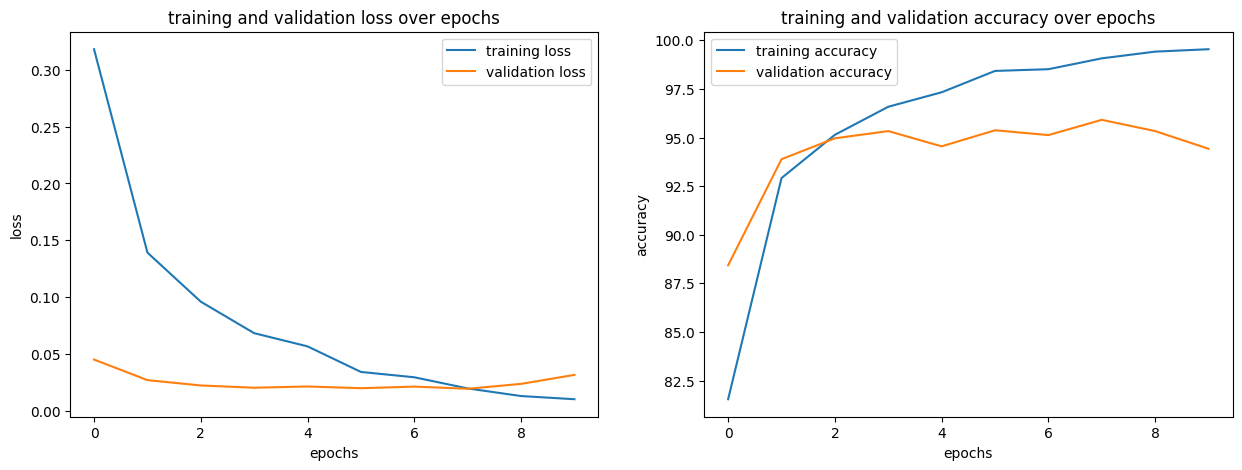

In [52]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label = 'training loss')
axs[0].plot(total_loss_validation_plot, label='validation loss')
axs[0].set_title('training and validation loss over epochs')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = 'training accuracy')
axs[1].plot(total_acc_validation_plot, label='validation accuracy')
axs[1].set_title('training and validation accuracy over epochs')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy')
axs[1].legend()

plt.show()

In [61]:
def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)
  print(image.unsqueeze(0).shape)
  print(image.shape)
  output = model(image.unsqueeze(0))
  output = torch.argmax(output,axis=1).item()
  return label_encoder.inverse_transform([output])

In [62]:
predict_image("/content/orange-tabby-domestic-cat-sits-600nw-2642830903.jpg.webp")

torch.Size([1, 3, 128, 128])
torch.Size([3, 128, 128])


array(['dog'], dtype=object)